In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

## OMTF definitions and imports

In [1]:
import glob

import tensorflow as tf
import tensorflow_addons as tfa

import os
import time
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import scipy

inputDataPrefix = ""

SLURM_CLUSTER_NAME=str(os.getenv("SLURM_CLUSTER_NAME"))
runOnCluster = False
if SLURM_CLUSTER_NAME == "prometheus":
    inputDataPrefix = "/net/people/plgakalinow/plggcmsml/"
    runOnCluster = True
elif SLURM_CLUSTER_NAME == "rysy":   
    inputDataPrefix = "/home/akalinow/"
    runOnCluster = True
else: 
    inputDataPrefix =  "/home/user1/scratch_ssd/akalinow/"
    runOnCluster = False
    
trainDataDir = inputDataPrefix+"/ProgrammingProjects/MachineLearning/OMTF/data/18_12_2020/"   
testDataDir = inputDataPrefix+"/ProgrammingProjects/MachineLearning/OMTF/data/18_12_2020/" 

nRefLayers = 8
nLayers = 18
nPDFBins = 2**7
minProbability = 0.001
minPlog = np.log(minProbability)
nPdfValBits = 6
refLayers = [0, 7, 2, 6, 16, 4, 10, 11]
ptBins = tf.concat([tf.range(0.0, 5, 0.5), tf.range(5, 30, 1.0, ), tf.range(30, 40, 5.0), tf.range(40, 60, 10.0), tf.range(60, 101, 20.0), [99999.0]], axis=0)

## Use mixed precision policy: 32 bits for data, 16 bits for weights

In [2]:
from tensorflow.keras.mixed_precision import experimental as mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_policy(policy)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: GeForce RTX 2070 SUPER, compute capability 7.5
Instructions for updating:
Use tf.keras.mixed_precision.LossScaleOptimizer instead. LossScaleOptimizer now has all the functionality of DynamicLossScale


## Start Tensorboard server

In [ ]:
if not runOnCluster:
    %load_ext tensorboard
    %tensorboard --logdir logs/fit --port=8008 --bind_all

## Data manipulation functions

In [4]:
columns = np.array(['muonPt', 'muonEta', 'muonPhi', 'muonCharge', 'omtfPt', 'omtfEta',
       'omtfPhi', 'omtfCharge', 'omtfScore', 'omtfQuality', 'omtfRefLayer',
       'omtfProcessor', 'omtfFiredLayers', 'phiDist_0', 'phiDist_1',
       'phiDist_2', 'phiDist_3', 'phiDist_4', 'phiDist_5', 'phiDist_6',
       'phiDist_7', 'phiDist_8', 'phiDist_9', 'phiDist_10', 'phiDist_11',
       'phiDist_12', 'phiDist_13', 'phiDist_14', 'phiDist_15', 'phiDist_16',
       'phiDist_17'])

def getFeaturesMask():
    featuresMask = np.full_like(columns, False, dtype=np.bool)
    for iLayer in range(0, 18):
        featureLabel = "phiDist_{}".format(iLayer)
        featuresMask += (columns==featureLabel)
    #featuresMask += columns=="omtfFiredLayers"
    #featuresMask += columns=="omtfRefLayer"
    #featuresMask += columns=="omtfPt"
    #featuresMask = columns=="omtfQuality"
    return featuresMask

def getFeature(name, dataRow):
    columnIndex = np.where(columns == name)[0][0]  
    return dataRow[:,columnIndex]

def parse_tensor(tensor):
    return tf.io.parse_tensor(tensor, out_type=tf.float32)

def pT2Label(tensor):
    tensor = tf.searchsorted(ptBins, tensor, side='left')
    return tensor
    
def label2Pt(tensor):  
    return tf.where(ptBins.numpy()[tensor]<9999, ptBins.numpy()[tensor], [200])

def modifyFeatures(dataRow, batchSize, isTrain=False):
    columnsMask = getFeaturesMask()
    features = tf.boolean_mask(dataRow, columnsMask, axis=1)
    dummyValue = 128 
    features = tf.where(features<9999, features, dummyValue) 
    features.set_shape([batchSize,np.count_nonzero(columnsMask)])
    features = tf.one_hot(tf.cast(features+64, dtype=tf.int32), depth=128)#TEST
    
    columnIndex = np.where(columns == "muonCharge")[0][0]  
    chargeLabels = (dataRow[:,columnIndex]+1)/2 
    chargeLabels.set_shape([batchSize,])
    
    columnIndex = np.where(columns == "muonPt")[0][0]
    ptLabels = dataRow[:,columnIndex]
    ptLabels.set_shape([batchSize,])
    trainWeight = 1.0 #tf.exp(-ptLabels/35.0)
    
    if isTrain:
        ptLabels = pT2Label(ptLabels)
        return (features, (ptLabels, chargeLabels), trainWeight)
    else:
        columnIndex = np.where(columns == "omtfPt")[0][0]  
        omtfPt = dataRow[:,columnIndex]
        columnIndex = np.where(columns == "omtfQuality")[0][0]  
        omtfQuality = dataRow[:,columnIndex]
        omtfPt = tf.where(omtfQuality>=12, omtfPt, 0) 
        omtfPt.set_shape([batchSize,])
        
        columnIndex = np.where(columns == "omtfCharge")[0][0]  
        omtfCharge = dataRow[:,columnIndex]
        omtfCharge = (omtfCharge+1)/2 
        omtfCharge.set_shape([batchSize,])
        return (features, (ptLabels, chargeLabels), omtfPt, omtfCharge)
    return dataRow
    
def loadDataset(fileNames, isTrain, nEpochs=1, batchSize=1):   
    raw_dataset = tf.data.TFRecordDataset(fileNames, compression_type="GZIP")
    dataset = raw_dataset.map(parse_tensor,num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.batch(batchSize, drop_remainder=True)
    #Split data into [features, labels] and modify features
    dataset = dataset.map(lambda x: modifyFeatures(x, batchSize, isTrain),num_parallel_calls=tf.data.experimental.AUTOTUNE)
    #dataset = dataset.cache('/scratch/akalinow/data_cache/')
    return dataset

def benchmark(dataset, num_epochs=2):
    start_time = time.perf_counter()
    for epoch_num in range(num_epochs):
        for sample in dataset:
            # Performing a training step
            time.sleep(1E-10)
    tf.print("Execution time:", time.perf_counter() - start_time)

## Utility functions

In [128]:
def finalModelAnswer(predictions, cumulativePosteriorCut):
    pt = tf.cumsum(predictions[0], axis=1)>cumulativePosteriorCut
    pt = tf.argmax(pt, axis=1)
    probability = np.amax(predictions[0], axis=1)
    pt*=(probability>0.05)
    charge = tf.cast(predictions[1]>0.5, dtype=tf.float32)
    charge =  tf.reshape(charge, (-1))
    return label2Pt(pt), charge, probability

def fillPandasDataset(aBatch, df, cumulativePosteriorCut):    
    features = aBatch[0]
    labels = aBatch[1]
    omtfPredictions = aBatch[2:4]
    probability = model.predict(features, use_multiprocessing=True)
    value = finalModelAnswer(probability, cumulativePosteriorCut)
    batch_df = pd.DataFrame(data={"genPt":labels[0], "genCharge":labels[1], 
                                    "OMTF_pt":omtfPredictions[0], 
                                    "OMTF_charge":omtfPredictions[1], 
                                    "NN_pt": value[0]*(omtfPredictions[0]>0),
                                    "NN_charge":value[1],
                                    "NN_prob":value[2],
                                    })
    return df.append(batch_df, ignore_index=True)

## Data reading test

In [ ]:
trainFileNames = glob.glob(trainDataDir+'OMTFHits_pats0x0003_newerSample_files_1_100_chunk_0.tfrecord.gzip')
train_dataset = loadDataset(trainFileNames, isTrain=True, nEpochs=1, batchSize=1)

#dataset = train_dataset.take(10000)
#benchmark(dataset)
#benchmark(dataset.prefetch(tf.data.experimental.AUTOTUNE))

#mask = tf.constant([0,1,2,3,10,11,12,13], dtype=tf.int32)
#print(mask)

for element in train_dataset.take(10): 
  print(element[0][0][17])
  #x = tf.one_hot(tf.cast(element[0], dtype=tf.int32), depth=128)
  #print(x.shape)  
  #y = tf.gather(params=element[0], indices=mask, axis=1)
  #print(y)  
  break

## Define models

In [6]:
def pull_mean_metric(y_true, y_pred):    
    predictions = tf.math.cumsum(y_pred, axis=1)>cumulativePosteriorCut
    predictions = tf.math.argmax(predictions, axis=1)   
    predictions = label2Pt(predictions)
    predictions = tf.reshape(predictions, (-1,1))
    labels = label2Pt(tf.cast(y_true, tf.int32))
    pull = (labels - predictions)/labels   
    mean = tf.math.reduce_mean(pull, axis=0)
    return mean 
    
def pull_variance_metric(y_true, y_pred):
    predictions = tf.math.cumsum(y_pred, axis=1)>cumulativePosteriorCut
    predictions = tf.math.argmax(predictions, axis=1)   
    predictions = label2Pt(predictions)
    predictions = tf.reshape(predictions, (-1,1))
    labels = label2Pt(tf.cast(y_true, tf.int32))
    pull = (labels - predictions)/labels  
    variance = tf.math.reduce_variance(pull, axis=0) 
    return tf.sqrt(variance) 

def my_loss_fn(y_true, y_pred):
    
    predictions = tf.math.cumsum(y_pred, axis=1)>cumulativePosteriorCut
    predictions = tf.math.argmax(predictions, axis=1)
    predictions = tf.reshape(predictions, (-1,1))
    #lowPtLoss = (labels<(10))*(predictions>(15))
    labels = y_true

    lowPtLoss = tf.math.logical_and(tf.math.less(labels, 10), tf.math.greater(predictions, 10))
    lowPtLoss = (predictions-labels)*lowPtLoss
    lowPtLoss = tf.cast(lowPtLoss, float32)
    
    return tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)(y_true, y_pred) + lowPtLoss


custom_objects={'pull_mean_metric': pull_mean_metric,
                'pull_variance_metric':pull_variance_metric,
                'my_loss_fn':my_loss_fn
               }

def getModel():
    
  nPtBins =  ptBins.shape[0]
  nInputs = np.sum(getFeaturesMask())
    
  inputs = tf.keras.Input(shape=(nInputs,128), name="deltaPhi")
  activation = tf.keras.activations.swish 
  #activation = tf.keras.activations.relu 
  
  ptLayer = tf.keras.layers.Flatten(input_shape=(nInputs, 128), name="Flatten_input_pt")(inputs) 
  #ptLayer = inputs
  for iLayer in range(0,3):
            ptLayer = tf.keras.layers.Dense(512, activation=activation, name="Pt_layer_{}".format(iLayer))(ptLayer)
    
  #chargeLayer= inputs  
  chargeLayer = tf.keras.layers.Flatten(input_shape=(nInputs, 128), name="Flatten_input_charge")(inputs) 
  for iLayer in range(0,1): 
       chargeLayer = tf.keras.layers.Dense(32, activation=activation, name="Charge_layer_{}".format(iLayer))(chargeLayer)
    
  ptOutput = tf.keras.layers.Dense(nPtBins, activation=tf.nn.softmax,bias_initializer='zeros',name = "pt")(ptLayer) 
  chargeOutput = tf.keras.layers.Dense(1, activation=tf.keras.activations.sigmoid,name = "charge")(chargeLayer)
        
  model = tf.keras.Model(inputs=inputs, outputs=[ptOutput, chargeOutput], name="NN")

  initial_learning_rate = 0.01
  lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=5000,
    decay_rate=0.95,
    staircase=True)
  
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
                loss={"pt":tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                     "charge":tf.keras.losses.BinaryCrossentropy(from_logits=False)
                     },                    
                metrics=['accuracy'])
  tf.keras.utils.plot_model(model, 'fig_png/ML_model.png', show_shapes=True)
  return model


def loadModel(checkpoint_path):
    return tf.keras.models.load_model(checkpoint_path.format(epoch=nEpochsSaved), custom_objects=custom_objects)

getModel()

  opt = tf.keras.mixed_precision.experimental.LossScaleOptimizer(opt)



## Train model

In [ ]:
current_time = datetime.now().strftime("%b %d %Y %H:%M:%S")
print("Training start. Current Time =", current_time)

trainFileNames = glob.glob(trainDataDir+'OMTFHits_pats0x0003_oldSample_files_*_chunk_0.tfrecord.gzip')
validationFileNames = glob.glob(testDataDir+'OMTFHits_pats0x0003_newerSample_files_1_100_chunk_0.tfrecord.gzip')

train_dataset = loadDataset(trainFileNames, isTrain=True, nEpochs=1, batchSize=4*4096)
validation_dataset = loadDataset(validationFileNames, isTrain=True, nEpochs=1, batchSize=1024)

model = getModel()

#nEpochsSaved = 5
#checkpoint_path = "training/model_full_{epoch:04d}"
#model = loadModel(checkpoint_path)

log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, profile_batch=(110, 120))

nEpochs = 200
history = model.fit(train_dataset, epochs=nEpochs,
                            use_multiprocessing=True,
                            verbose=1,
                            shuffle=False,
                            validation_data=validation_dataset.take(10),
                            callbacks=[tensorboard_callback]
                           )
# Save the whole model
path = "training/model_full_{epoch:04d}"
model.save(path.format(epoch=nEpochs), save_format='tf')
#Save model weights
path = "training/model_weights_{epoch:04d}.ckpt"
model.save_weights(path.format(epoch=nEpochs))

current_time = datetime.now().strftime("%b %d %Y %H:%M:%S")
print("Training end. Current Time =", current_time)

## Model evaluation

The plots show the "posterior" probability that a given muons has $p_{T}$ in given bin. The correct behaviour is a peak round the true value, marked by a gren line.
Unfortunetly a small fraction of muons with very low true $p_{T}$, around a few GeV/c receive a vey large $p_{T}$ assigned by the NN: this is a big bump around 100 GeV/c.
This can be seen on the second plot: a efficency plot, where Y axis show fraction of muons with true $p_{T}$ marked by the X value, that get a NN or OMTF (human designed algorithm) greater or equal to 20 GeV/c. A small peak arount 3 GeV/c is visible. **Although this is small, it has very bad consequences, and has to be removed.**

In [ ]:
import pandas as pd
import importlib
import plottingFunctions as plf
importlib.reload(plf)

cumulativePosteriorCut = 0.65

if not runOnCluster:
    
    current_time = datetime.now().strftime("%b %d %Y %H:%M:%S")   
    print("Inference start. Current Time =", current_time)
    
    nEpochsSaved = 10
    checkpoint_path = "training/model_full_{epoch:04d}"
    model = tf.keras.models.load_model(checkpoint_path.format(epoch=nEpochsSaved), custom_objects=custom_objects)

    testFileNames = glob.glob(testDataDir+'OMTFHits_pats0x0003_newerSample_files_1_100_chunk_0.tfrecord.gzip')    
    test_dataset = loadDataset(testFileNames, isTrain=False, nEpochs=1, batchSize=32*1024)
    
    df = pd.DataFrame(columns=["genPt", "genCharge", 
                                "OMTF_pt","OMTF_charge",
                                "NN_pt","NN_charge","NN_prob"])
    for aBatch in test_dataset.as_numpy_iterator():
        df = fillPandasDataset(aBatch, df, cumulativePosteriorCut)
        
        #predictions = model.predict(aBatch[0], use_multiprocessing=True)
        #plf.plotPosterior(3, labels=aBatch[1][0], predictions=predictions[0], label2Pt=label2Pt)
        #break
    
    
    plf.plotTurnOn(df, ptCut=5)
    plf.plotTurnOn(df, ptCut=20)
    plf.plotTurnOn(df, ptCut=22)
    plf.plotTurnOn(df, ptCut=30)
    plf.plotTurnOn(df, ptCut=50)
    plf.plotTurnOn(df, ptCut=100)
    plf.plotTurnOn(df, ptCut=200)
    plf.plotPull(df)
    plf.plotCM(df, pT2Label)
    plf.plotRate(df)
    
    current_time = datetime.now().strftime("%b %d %Y %H:%M:%S")
    print("Inference end. Current Time =", current_time)

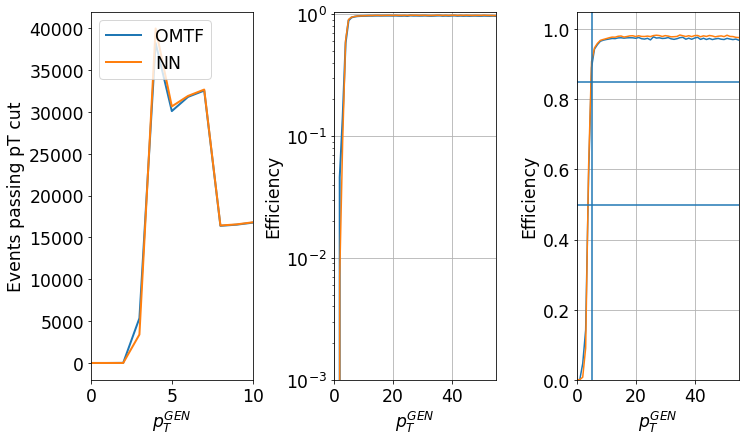

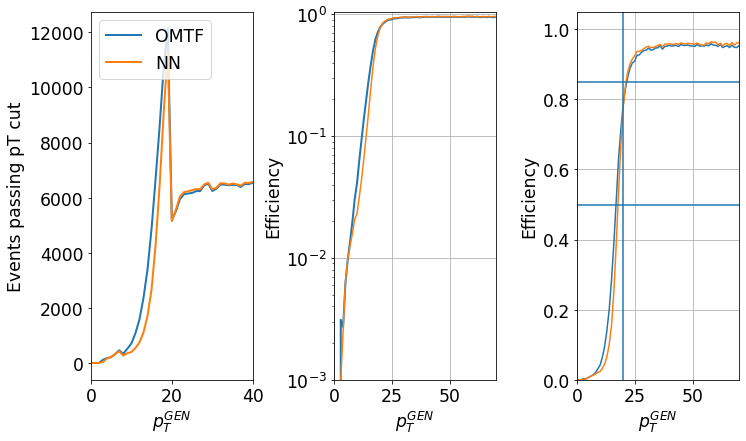

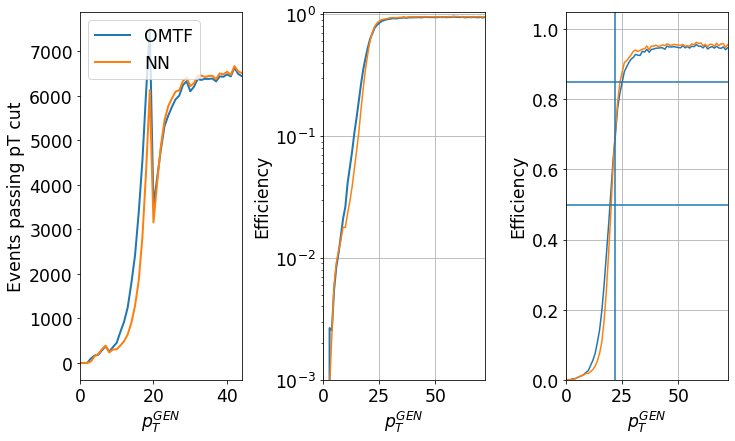

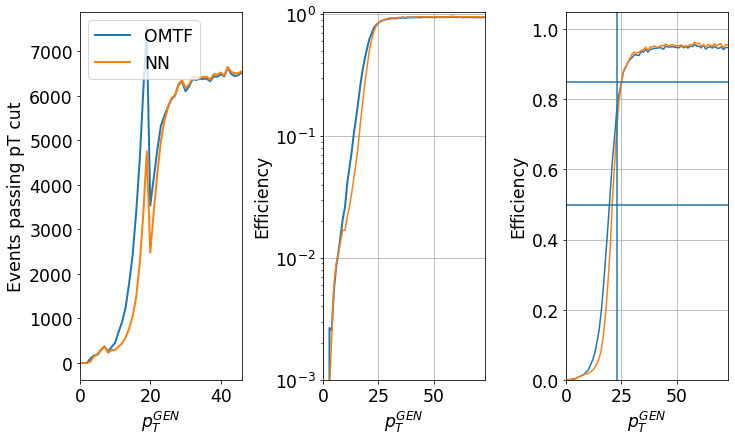

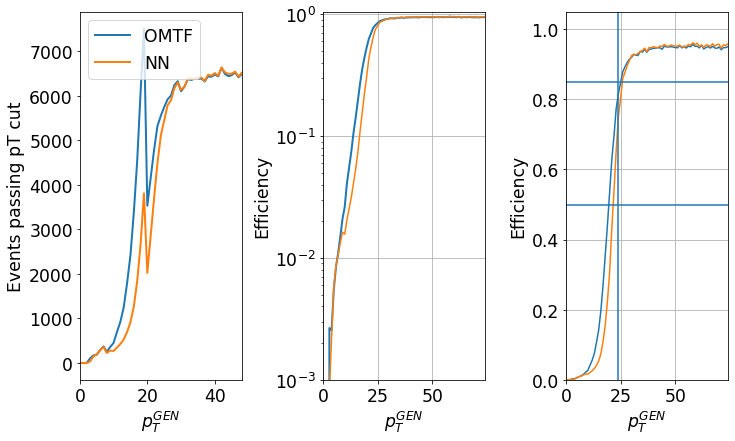

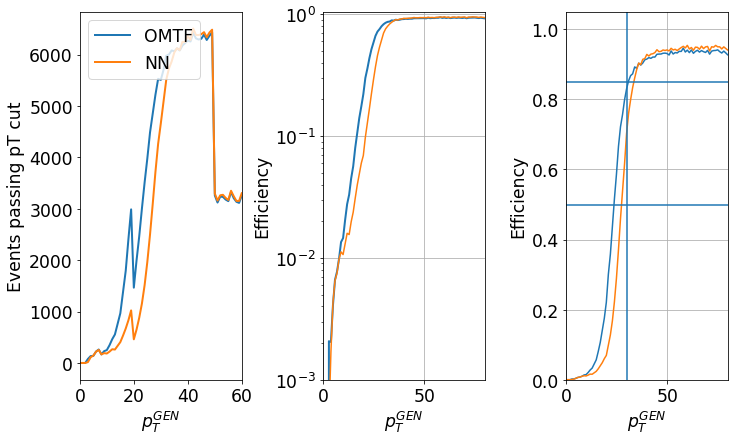

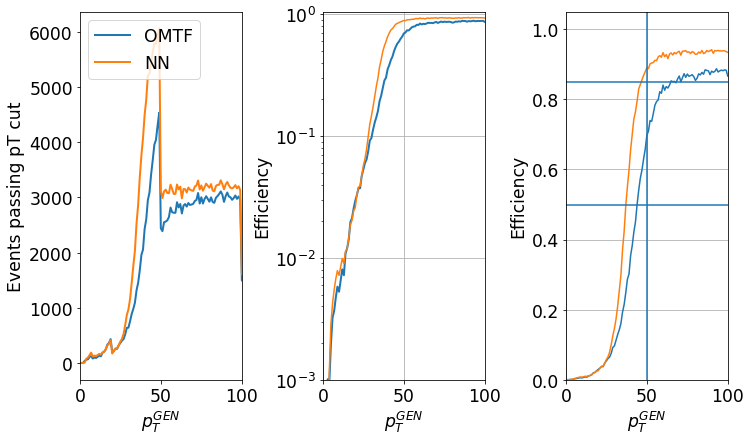

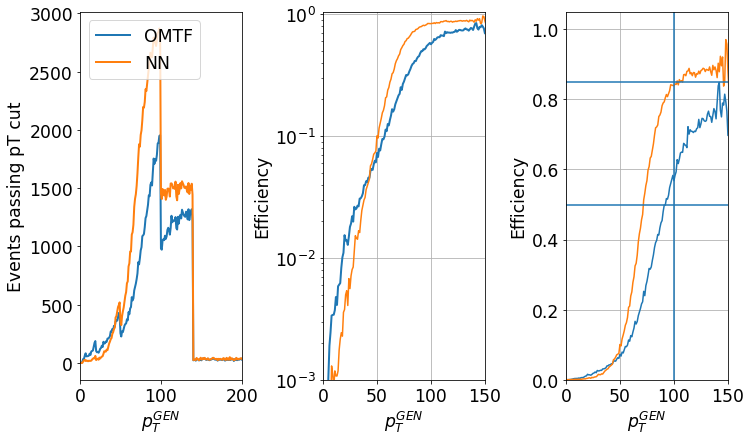

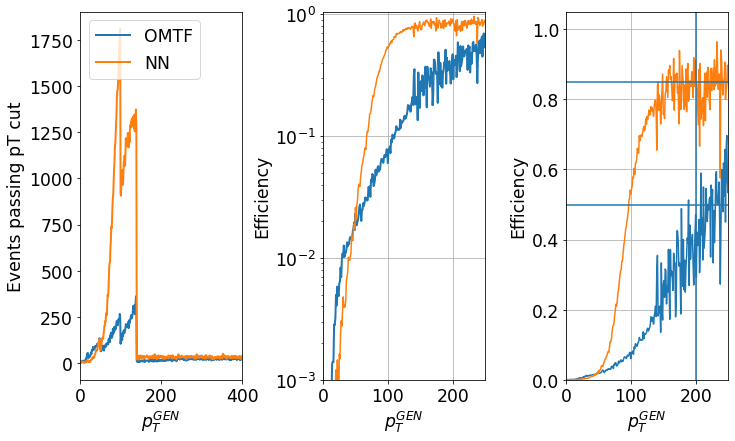

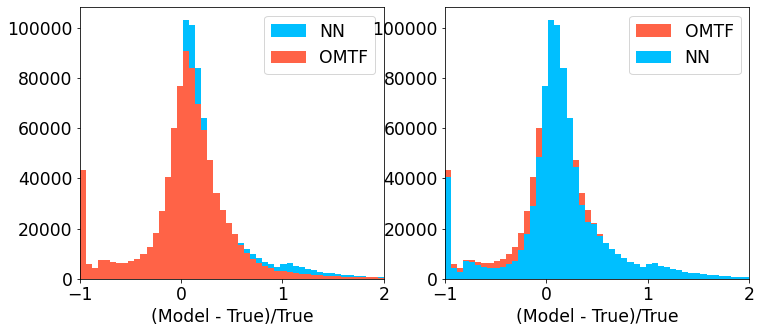

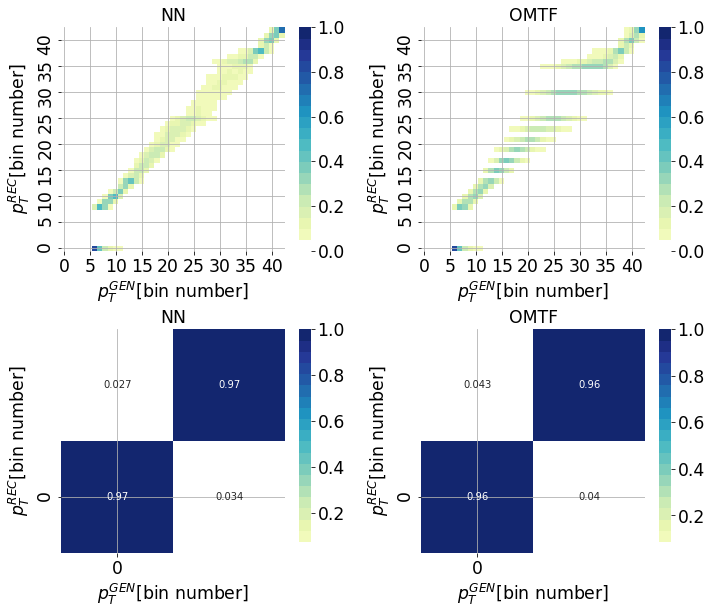

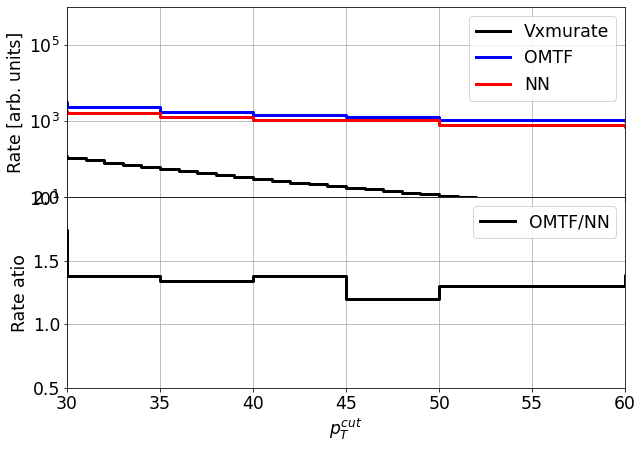

In [177]:
import plottingFunctions as plf
importlib.reload(plf)

#df1 = df[(df["genPt"]<10)&(df["genPt"]>0)]
#plf.plotCM(df1, pT2Label)
#plf.plotPull(df1)

plf.plotTurnOn(df, ptCut=5)
plf.plotTurnOn(df, ptCut=20)
plf.plotTurnOn(df, ptCut=22)
plf.plotTurnOn(df, ptCut=23)
plf.plotTurnOn(df, ptCut=24)
plf.plotTurnOn(df, ptCut=30)
plf.plotTurnOn(df, ptCut=50)
plf.plotTurnOn(df, ptCut=100)
plf.plotTurnOn(df, ptCut=200)
plf.plotPull(df)
plf.plotCM(df, pT2Label)
plf.plotRate(df)